# Clustering Houses based on daily consumption

In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
pd.set_option('display.max_columns', None)

In [2]:
daily = pd.read_csv('./datasets/london_smart_meters/daily_master.csv')

In [3]:
daily['day'] = daily['Unnamed: 0']
daily = daily.loc[:, ['LCLid', 'Acorn', 'day', 'energy_median', 'energy_mean', 'energy_max', 'energy_std', 'energy_sum', 'energy_min']].copy()

### First, plot consumption by acorn

In [4]:
corn = daily[['LCLid', 'Acorn', 'day', 'energy_sum']]

In [5]:
corn.head()

,LCLid,Acorn,day,energy_sum
0,MAC000152,ACORN-E,2011-11-23,5.969
1,MAC000153,ACORN-E,2011-11-23,21.702
2,MAC000156,ACORN-F,2011-11-23,6.523
3,MAC000147,ACORN-F,2011-11-23,3.036
4,MAC000154,ACORN-Q,2011-11-23,5.798


#### Pivot the data so that days are columns and houses are the rows with energy sums in each cell

In [6]:
corn['LCLid'].unique().shape

(5534,)

In [7]:
new_corn = corn.pivot(index='LCLid', columns='day', values='energy_sum')

In [8]:
new_corn.columns[293]

'2012-09-11'

#### Index the columns after september 2012 (index 293) because a majority of previous dates have nulls

In [9]:
new_corn = new_corn.loc[:, list(new_corn.columns[293::])].dropna()

In [10]:
new_corn.shape

(4139, 536)

In [11]:
new_corn.head()

day,2012-09-11,2012-09-12,2012-09-13,2012-09-14,2012-09-15,2012-09-16,2012-09-17,2012-09-18,2012-09-19,2012-09-20,2012-09-21,2012-09-22,2012-09-23,2012-09-24,2012-09-25,2012-09-26,2012-09-27,2012-09-28,2012-09-29,2012-09-30,2012-10-01,2012-10-02,2012-10-03,2012-10-04,2012-10-05,2012-10-06,2012-10-07,2012-10-08,2012-10-09,2012-10-10,2012-10-11,2012-10-12,2012-10-13,2012-10-14,2012-10-15,2012-10-16,2012-10-17,2012-10-18,2012-10-19,2012-10-20,2012-10-21,2012-10-22,2012-10-23,2012-10-24,2012-10-25,2012-10-26,2012-10-27,2012-10-28,2012-10-29,2012-10-30,2012-10-31,2012-11-01,2012-11-02,2012-11-03,2012-11-04,2012-11-05,2012-11-06,2012-11-07,2012-11-08,2012-11-09,2012-11-10,2012-11-11,2012-11-12,2012-11-13,2012-11-14,2012-11-15,2012-11-16,2012-11-17,2012-11-18,2012-11-19,2012-11-20,2012-11-21,2012-11-22,2012-11-23,2012-11-24,2012-11-25,2012-11-26,2012-11-27,2012-11-28,2012-11-29,2012-11-30,2012-12-01,2012-12-02,2012-12-03,2012-12-04,2012-12-05,2012-12-06,2012-12-07,2012-12-08,2012-12-09,2012-12-10,2012-12-11,2012-12-12,2012-12-13,2012-12-14,2012-12-15,2012-12-16,2012-12-17,2012-12-18,2012-12-19,2012-12-20,2012-12-21,2012-12-22,2012-12-23,2012-12-24,2012-12-25,2012-12-26,2012-12-27,2012-12-28,2012-12-29,2012-12-30,2012-12-31,2013-01-01,2013-01-02,2013-01-03,2013-01-04,2013-01-05,2013-01-06,2013-01-07,2013-01-08,2013-01-09,2013-01-10,2013-01-11,2013-01-12,2013-01-13,2013-01-14,2013-01-15,2013-01-16,2013-01-17,2013-01-18,2013-01-19,2013-01-20,2013-01-21,2013-01-22,2013-01-23,2013-01-24,2013-01-25,2013-01-26,2013-01-27,2013-01-28,2013-01-29,2013-01-30,2013-01-31,2013-02-01,2013-02-02,2013-02-03,2013-02-04,2013-02-05,2013-02-06,2013-02-07,2013-02-08,2013-02-09,2013-02-10,2013-02-11,2013-02-12,2013-02-13,2013-02-14,2013-02-15,2013-02-16,2013-02-17,2013-02-18,2013-02-19,2013-02-20,2013-02-21,2013-02-22,2013-02-23,2013-02-24,2013-02-25,2013-02-26,2013-02-27,2013-02-28,2013-03-01,2013-03-02,2013-03-03,2013-03-04,2013-03-05,2013-03-06,2013-03-07,2013-03-08,2013-03-09,2013-03-10,2013-03-11,2013-03-12,2013-03-13,2013-03-14,2013-03-15,2013-03-16,2013-03-17,2013-03-18,2013-03-19,2013-03-20,2013-03-21,2013-03-22,2013-03-23,2013-03-24,2013-03-25,2013-03-26,2013-03-27,2013-03-28,2013-03-29,2013-03-30,2013-03-31,2013-04-01,2013-04-02,2013-04-03,2013-04-04,2013-04-05,2013-04-06,2013-04-07,2013-04-08,2013-04-09,2013-04-10,2013-04-11,2013-04-12,2013-04-13,2013-04-14,2013-04-15,2013-04-16,2013-04-17,2013-04-18,2013-04-19,2013-04-20,2013-04-21,2013-04-22,2013-04-23,2013-04-24,2013-04-25,2013-04-26,2013-04-27,2013-04-28,2013-04-29,2013-04-30,2013-05-01,2013-05-02,2013-05-03,2013-05-04,2013-05-05,2013-05-06,2013-05-07,2013-05-08,2013-05-09,2013-05-10,2013-05-11,2013-05-12,2013-05-13,2013-05-14,2013-05-15,2013-05-16,2013-05-17,2013-05-18,2013-05-19,2013-05-20,2013-05-21,2013-05-22,2013-05-23,2013-05-24,2013-05-25,2013-05-26,2013-05-27,2013-05-28,2013-05-29,2013-05-30,2013-05-31,2013-06-01,2013-06-02,2013-06-03,2013-06-04,2013-06-05,2013-06-06,2013-06-07,2013-06-08,2013-06-09,2013-06-10,2013-06-11,2013-06-12,2013-06-13,2013-06-14,2013-06-15,2013-06-16,2013-06-17,2013-06-18,2013-06-19,2013-06-20,2013-06-21,2013-06-22,2013-06-23,2013-06-24,2013-06-25,2013-06-26,2013-06-27,2013-06-28,2013-06-29,2013-06-30,2013-07-01,2013-07-02,2013-07-03,2013-07-04,2013-07-05,2013-07-06,2013-07-07,2013-07-08,2013-07-09,2013-07-10,2013-07-11,2013-07-12,2013-07-13,2013-07-14,2013-07-15,2013-07-16,2013-07-17,2013-07-18,2013-07-19,2013-07-20,2013-07-21,2013-07-22,2013-07-23,2013-07-24,2013-07-25,2013-07-26,2013-07-27,2013-07-28,2013-07-29,2013-07-30,2013-07-31,2013-08-01,2013-08-02,2013-08-03,2013-08-04,2013-08-05,2013-08-06,2013-08-07,2013-08-08,2013-08-09,2013-08-10,2013-08-11,2013-08-12,2013-08-13,2013-08-14,2013-08-15,2013-08-16,2013-08-17,2013-08-18,2013-08-19,2013-08-20,2013-08-21,2013-08-22,2013-08-23,2013-08-24,2013-08-25,2013-08-26,2013-08-27,2013-08-28,2013-08-29,2013-08-30,2013-08-31,2013-09-01,2013-09-02,2013-09-03,2013-09-04,2013-09-05,2013-09-06,2013-09-07,2013-09-08,201

#### Now add in the acorn column

In [33]:
small_corn = corn[['LCLid', 'Acorn']]
small_corn.drop_duplicates(subset='LCLid', inplace=True)
small_corn.head()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,LCLid,Acorn
0,MAC000152,ACORN-E
1,MAC000153,ACORN-E
2,MAC000156,ACORN-F
3,MAC000147,ACORN-F
4,MAC000154,ACORN-Q


In [34]:
small_corn.set_index('LCLid', inplace=True)
small_corn.sort_index(inplace=True)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [35]:
all_houses = list(small_corn.index)
houses_to_keep = list(new_corn.index)

for house in all_houses:
    if house not in houses_to_keep:
        small_corn.drop(index=house, inplace=True)

In [38]:
new_corn = pd.merge(new_corn, small_corn, left_index=True, right_index=True, how='left')

In [41]:
new_corn.head()

,2012-09-11,2012-09-12,2012-09-13,2012-09-14,2012-09-15,2012-09-16,2012-09-17,2012-09-18,2012-09-19,2012-09-20,2012-09-21,2012-09-22,2012-09-23,2012-09-24,2012-09-25,2012-09-26,2012-09-27,2012-09-28,2012-09-29,2012-09-30,2012-10-01,2012-10-02,2012-10-03,2012-10-04,2012-10-05,2012-10-06,2012-10-07,2012-10-08,2012-10-09,2012-10-10,2012-10-11,2012-10-12,2012-10-13,2012-10-14,2012-10-15,2012-10-16,2012-10-17,2012-10-18,2012-10-19,2012-10-20,2012-10-21,2012-10-22,2012-10-23,2012-10-24,2012-10-25,2012-10-26,2012-10-27,2012-10-28,2012-10-29,2012-10-30,2012-10-31,2012-11-01,2012-11-02,2012-11-03,2012-11-04,2012-11-05,2012-11-06,2012-11-07,2012-11-08,2012-11-09,2012-11-10,2012-11-11,2012-11-12,2012-11-13,2012-11-14,2012-11-15,2012-11-16,2012-11-17,2012-11-18,2012-11-19,2012-11-20,2012-11-21,2012-11-22,2012-11-23,2012-11-24,2012-11-25,2012-11-26,2012-11-27,2012-11-28,2012-11-29,2012-11-30,2012-12-01,2012-12-02,2012-12-03,2012-12-04,2012-12-05,2012-12-06,2012-12-07,2012-12-08,2012-12-09,2012-12-10,2012-12-11,2012-12-12,2012-12-13,2012-12-14,2012-12-15,2012-12-16,2012-12-17,2012-12-18,2012-12-19,2012-12-20,2012-12-21,2012-12-22,2012-12-23,2012-12-24,2012-12-25,2012-12-26,2012-12-27,2012-12-28,2012-12-29,2012-12-30,2012-12-31,2013-01-01,2013-01-02,2013-01-03,2013-01-04,2013-01-05,2013-01-06,2013-01-07,2013-01-08,2013-01-09,2013-01-10,2013-01-11,2013-01-12,2013-01-13,2013-01-14,2013-01-15,2013-01-16,2013-01-17,2013-01-18,2013-01-19,2013-01-20,2013-01-21,2013-01-22,2013-01-23,2013-01-24,2013-01-25,2013-01-26,2013-01-27,2013-01-28,2013-01-29,2013-01-30,2013-01-31,2013-02-01,2013-02-02,2013-02-03,2013-02-04,2013-02-05,2013-02-06,2013-02-07,2013-02-08,2013-02-09,2013-02-10,2013-02-11,2013-02-12,2013-02-13,2013-02-14,2013-02-15,2013-02-16,2013-02-17,2013-02-18,2013-02-19,2013-02-20,2013-02-21,2013-02-22,2013-02-23,2013-02-24,2013-02-25,2013-02-26,2013-02-27,2013-02-28,2013-03-01,2013-03-02,2013-03-03,2013-03-04,2013-03-05,2013-03-06,2013-03-07,2013-03-08,2013-03-09,2013-03-10,2013-03-11,2013-03-12,2013-03-13,2013-03-14,2013-03-15,2013-03-16,2013-03-17,2013-03-18,2013-03-19,2013-03-20,2013-03-21,2013-03-22,2013-03-23,2013-03-24,2013-03-25,2013-03-26,2013-03-27,2013-03-28,2013-03-29,2013-03-30,2013-03-31,2013-04-01,2013-04-02,2013-04-03,2013-04-04,2013-04-05,2013-04-06,2013-04-07,2013-04-08,2013-04-09,2013-04-10,2013-04-11,2013-04-12,2013-04-13,2013-04-14,2013-04-15,2013-04-16,2013-04-17,2013-04-18,2013-04-19,2013-04-20,2013-04-21,2013-04-22,2013-04-23,2013-04-24,2013-04-25,2013-04-26,2013-04-27,2013-04-28,2013-04-29,2013-04-30,2013-05-01,2013-05-02,2013-05-03,2013-05-04,2013-05-05,2013-05-06,2013-05-07,2013-05-08,2013-05-09,2013-05-10,2013-05-11,2013-05-12,2013-05-13,2013-05-14,2013-05-15,2013-05-16,2013-05-17,2013-05-18,2013-05-19,2013-05-20,2013-05-21,2013-05-22,2013-05-23,2013-05-24,2013-05-25,2013-05-26,2013-05-27,2013-05-28,2013-05-29,2013-05-30,2013-05-31,2013-06-01,2013-06-02,2013-06-03,2013-06-04,2013-06-05,2013-06-06,2013-06-07,2013-06-08,2013-06-09,2013-06-10,2013-06-11,2013-06-12,2013-06-13,2013-06-14,2013-06-15,2013-06-16,2013-06-17,2013-06-18,2013-06-19,2013-06-20,2013-06-21,2013-06-22,2013-06-23,2013-06-24,2013-06-25,2013-06-26,2013-06-27,2013-06-28,2013-06-29,2013-06-30,2013-07-01,2013-07-02,2013-07-03,2013-07-04,2013-07-05,2013-07-06,2013-07-07,2013-07-08,2013-07-09,2013-07-10,2013-07-11,2013-07-12,2013-07-13,2013-07-14,2013-07-15,2013-07-16,2013-07-17,2013-07-18,2013-07-19,2013-07-20,2013-07-21,2013-07-22,2013-07-23,2013-07-24,2013-07-25,2013-07-26,2013-07-27,2013-07-28,2013-07-29,2013-07-30,2013-07-31,2013-08-01,2013-08-02,2013-08-03,2013-08-04,2013-08-05,2013-08-06,2013-08-07,2013-08-08,2013-08-09,2013-08-10,2013-08-11,2013-08-12,2013-08-13,2013-08-14,2013-08-15,2013-08-16,2013-08-17,2013-08-18,2013-08-19,2013-08-20,2013-08-21,2013-08-22,2013-08-23,2013-08-24,2013-08-25,2013-08-26,2013-08-27,2013-08-28,2013-08-29,2013-08-30,2013-08-31,2013-09-01,2013-09-02,2013-09-03,2013-09-04,2013-09-05,2013-09-06,2013-09-07,2013-09-08,2013-0

### Now run PCA on the new data frame

In [46]:
# X_train, X_test = train_test_split(new_corn.drop(columns='Acorn'), random_state=24)

# ss = StandardScaler()
# X_train = ss.fit_transform(X_train)
# X_test = ss.transform(X_test)

In [74]:
ss = StandardScaler()

X = ss.fit_transform(new_corn.drop(columns='Acorn'))
pca = PCA(random_state=24)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=24,
    svd_solver='auto', tol=0.0, whiten=False)

In [75]:
z = pca.transform(X)

In [76]:
# Pull the explained variance attribute.
var_exp = pca.explained_variance_ratio_
print(f'Explained variance (first 20 components): {np.round(var_exp[:20], 3)}')

print('')

# Generate the cumulative explained variance.
cum_var_exp = np.cumsum(var_exp)
print(f'Cumulative explained variance (first 20 components): {np.round(cum_var_exp[:20], 3)}')

Explained variance (first 20 components): [0.725 0.06  0.021 0.011 0.008 0.008 0.006 0.005 0.004 0.004 0.003 0.003
 0.003 0.003 0.003 0.002 0.002 0.002 0.002 0.002]

Cumulative explained variance (first 20 components): [0.725 0.785 0.806 0.816 0.824 0.832 0.837 0.842 0.846 0.85  0.853 0.856
 0.859 0.862 0.865 0.867 0.869 0.871 0.874 0.875]


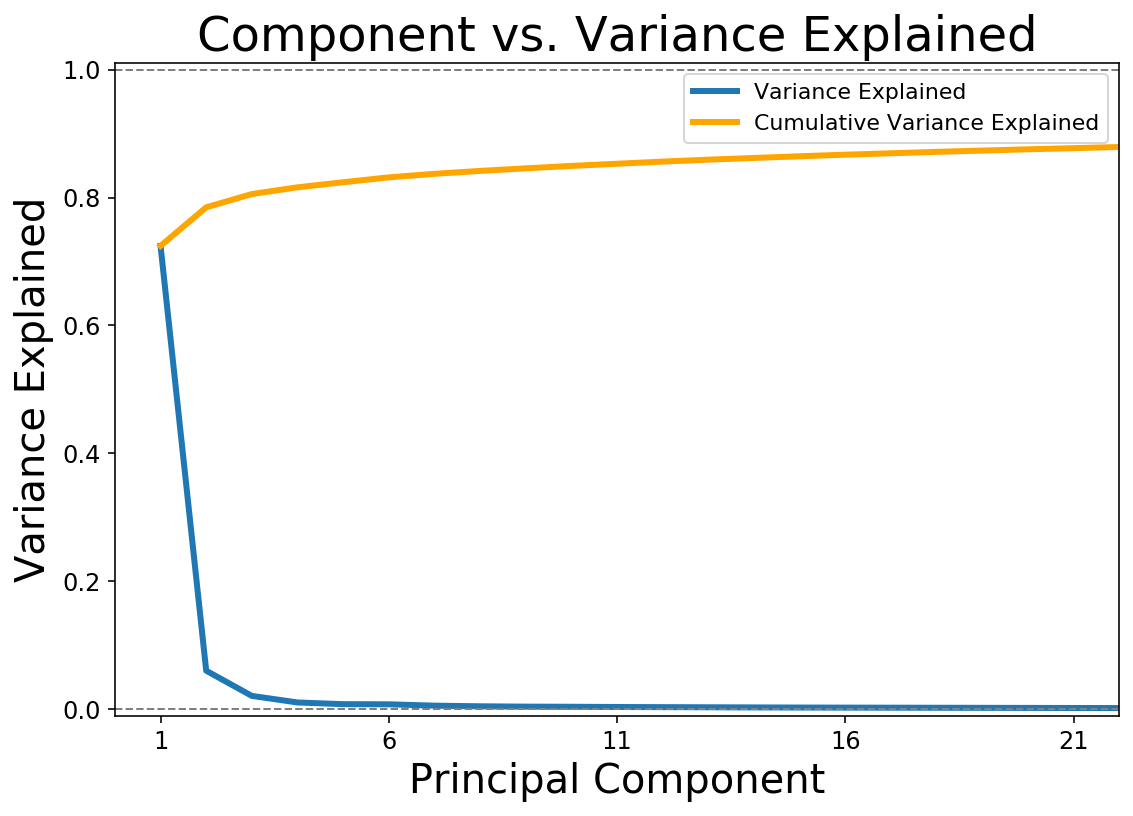

In [77]:
# Plot the variance explained (and cumulative variance explained).

# Set figure size.
plt.figure(figsize=(9,6))

# Plot the explained variance.
plt.plot(range(len(var_exp)), var_exp, lw=3, label = 'Variance Explained')

# Plot the cumulative explained variance.
plt.plot(range(len(var_exp)), cum_var_exp, lw=3, color = 'orange', label = 'Cumulative Variance Explained')

# Add horizontal lines at y=0 and y=1.
plt.axhline(y=0, linewidth=1, color='grey', ls='dashed')
plt.axhline(y=1, linewidth=1, color='grey', ls='dashed')

# Set the limits of the axes.
plt.xlim([-1,21])
plt.ylim([-0.01,1.01])

# Label the axes.
plt.ylabel('Variance Explained', fontsize=20)
plt.xlabel('Principal Component', fontsize=20)

# Make the tick labels bigger
plt.xticks(range(0, 21, 5), range(1, 22, 5), fontsize=12)
plt.yticks(fontsize=12)
    
# Add title and legend.
plt.title('Component vs. Variance Explained', fontsize=24)
plt.legend(fontsize=11);

#### The explained variance drops of sharply after the first component showing that PCA did a poor job at finding separating the data

### plot the first two principal components

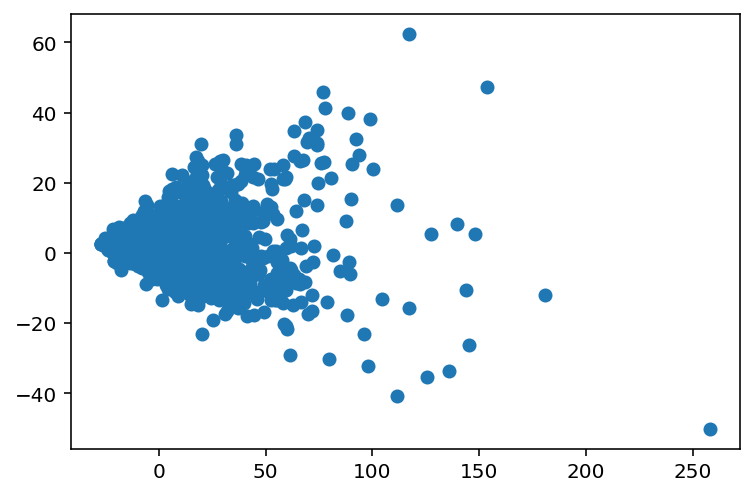

In [85]:
plt.scatter(z[:,0], z[:,1])

In [80]:
z_df = pd.DataFrame(z)
z_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535
0,25.578572,11.783411,-9.330652,-3.867303,-0.385694,4.254200,1.125234,-1.291555,-1.356474,1.701954,1.345449,-2.439474,-0.956717,1.427390,-2.038133,-1.645054,2.420905,-1.600977,0.009343,0.712290,1.076406,-3.170111,1.268991,0.909054,2.054181,0.269177,1.033334,-2.338822,1.411574,0.333788,1.829708,-0.076873,0.430149,-0.182375,0.739575,-0.682703,1.764242,-1.704783,0.009685,2.290829,-1.209599,-0.417067,-1.830092,-2.124866,-0.826161,-3.538770,-0.193700,-0.912834,1.040413,-1.183490,-1.905020,0.378176,-1.517957,0.459292,0.549666,-0.923300,1.520191,0.103581,0.703689,-3.406849,1.634800,-0.254498,-1.725494,3.857845,-1.614040,-2.081278,-0.179243,0.138011,-0.326866,-1.706152,-0.912007,1.578505,0.564915,1.547990,0.649050,0.688995,-0.770386,0.256439,-1.594757,0.990983,0.943281,0.273383,0.008808,0.436036,-0.128416,0.667824,1.011621,-1.014181,0.326640,0.468575,-0.129309,-0.411581,-0.566031,0.229354,2.101453,-1.355487,1.514391,0.455865,-1.736100,2.097118,-0.194684,-0.920247,1.476591,1.423827,0.122454,-0.430087,-0.595873,-1.655138,-0.947801,-1.057979,0.681477,-0.932113,-1.385474,-0.469645,-1.518504,-0.397017,-0.540469,0.176462,-2.110823,-0.221531,-0.656460,-1.133162,2.040044,-1.150320,-0.028637,-0.030943,0.476652,0.263909,-0.090492,-0.429236,-1.973788,-0.956062,-0.628704,0.574463,-0.488662,-1.543427,1.236386,-0.832827,1.399878,0.660004,0.179035,-0.400892,-0.495676,0.275620,0.798363,1.569459,-0.955101,0.232977,0.989448,-0.402252,2.296542,1.373770,0.957680,-0.907001,-0.352769,-0.439755,0.152857,-1.983175,0.303599,-0.071172,1.478294,0.507286,-0.802277,-0.052027,-0.315875,1.190164,0.394561,0.727442,0.655027,1.004511,-1.211576,-1.456799,-1.072891,-0.638912,-1.136390,-0.005604,-0.873976,-1.163428,-0.507272,-0.367561,-0.192042,1.832840,-0.138797,-0.564154,-0.305436,0.917770,-0.312166,-0.079183,-0.650464,-1.031800,-0.367149,-0.732727,-1.067369,-0.170781,1.160137,0.515416,-1.493083,-0.755949,0.574794,-0.578576,-0.989575,0.091666,-0.360975,-0.024968,0.400244,-0

In [83]:
z_df['acorns'] = new_corn['Acorn'].values

In [88]:
bigger_acorns = {
    "ACORN-A": "affluent_achievers",
    "ACORN-B": "affluent_achievers",
    "ACORN-C": "affluent_achievers",
    "ACORN-D": "rising_prosperity",
    "ACORN-E": "rising_prosperity",
    "ACORN-F": "comfortable_communities",
    "ACORN-G": "comfortable_communities",
    "ACORN-H": "comfortable_communities",
    "ACORN-I": "comfortable_communities",
    "ACORN-J": "comfortable_communities",
    "ACORN-K": "financially_stretched",
    "ACORN-L": "financially_stretched",
    "ACORN-M": "financially_stretched",
    "ACORN-N": "financially_stretched",
    "ACORN-O": "urban_adversity",
    "ACORN-P": "urban_adversity",
    "ACORN-Q": "urban_adversity",
    "ACORN-R": "not_private_households"
}

In [92]:
bigger_acorn_digits = {
    "ACORN-A": 0,
    "ACORN-B": 0,
    "ACORN-C": 0,
    "ACORN-D": 1,
    "ACORN-E": 1,
    "ACORN-F": 2,
    "ACORN-G": 2,
    "ACORN-H": 2,
    "ACORN-I": 2,
    "ACORN-J": 2,
    "ACORN-K": 3,
    "ACORN-L": 3,
    "ACORN-M": 3,
    "ACORN-N": 3,
    "ACORN-O": 4,
    "ACORN-P": 4,
    "ACORN-Q": 4,
    "ACORN-R": 5
}

In [89]:
z_df['big_acorn'] = z_df['acorns'].map(bigger_acorns)

In [96]:
z_df['big_acorn_number'] = z_df['acorns'].map(bigger_acorn_digits)

In [97]:
big_acorn_colors = ["red", "green", "blue", "orange", "black"]
z_df['big_color'] = z_df['big_acorn_number'].map(lambda p: big_acorn_colors[p])

TypeError: list indices must be integers or slices, not float

In [94]:
z_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,acorns,big_acorn,big_acorn_number
0,25.578572,11.783411,-9.330652,-3.867303,-0.385694,4.254200,1.125234,-1.291555,-1.356474,1.701954,1.345449,-2.439474,-0.956717,1.427390,-2.038133,-1.645054,2.420905,-1.600977,0.009343,0.712290,1.076406,-3.170111,1.268991,0.909054,2.054181,0.269177,1.033334,-2.338822,1.411574,0.333788,1.829708,-0.076873,0.430149,-0.182375,0.739575,-0.682703,1.764242,-1.704783,0.009685,2.290829,-1.209599,-0.417067,-1.830092,-2.124866,-0.826161,-3.538770,-0.193700,-0.912834,1.040413,-1.183490,-1.905020,0.378176,-1.517957,0.459292,0.549666,-0.923300,1.520191,0.103581,0.703689,-3.406849,1.634800,-0.254498,-1.725494,3.857845,-1.614040,-2.081278,-0.179243,0.138011,-0.326866,-1.706152,-0.912007,1.578505,0.564915,1.547990,0.649050,0.688995,-0.770386,0.256439,-1.594757,0.990983,0.943281,0.273383,0.008808,0.436036,-0.128416,0.667824,1.011621,-1.014181,0.326640,0.468575,-0.129309,-0.411581,-0.566031,0.229354,2.101453,-1.355487,1.514391,0.455865,-1.736100,2.097118,-0.194684,-0.920247,1.476591,1.423827,0.122454,-0.430087,-0.595873,-1.655138,-0.947801,-1.057979,0.681477,-0.932113,-1.385474,-0.469645,-1.518504,-0.397017,-0.540469,0.176462,-2.110823,-0.221531,-0.656460,-1.133162,2.040044,-1.150320,-0.028637,-0.030943,0.476652,0.263909,-0.090492,-0.429236,-1.973788,-0.956062,-0.628704,0.574463,-0.488662,-1.543427,1.236386,-0.832827,1.399878,0.660004,0.179035,-0.400892,-0.495676,0.275620,0.798363,1.569459,-0.955101,0.232977,0.989448,-0.402252,2.296542,1.373770,0.957680,-0.907001,-0.352769,-0.439755,0.152857,-1.983175,0.303599,-0.071172,1.478294,0.507286,-0.802277,-0.052027,-0.315875,1.190164,0.394561,0.727442,0.655027,1.004511,-1.211576,-1.456799,-1.072891,-0.638912,-1.136390,-0.005604,-0.873976,-1.163428,-0.507272,-0.367561,-0.192042,1.832840,-0.138797,-0.564154,-0.305436,0.917770,-0.312166,-0.079183,-0.650464,-1.031800,-0.367149,-0.732727,-1.067369,-0.170781,1.160137,0.515416,-1.493083,-0.755949,0.574794,-0.578576,-0.989575,0.0916

In [99]:
import seaborn as sns

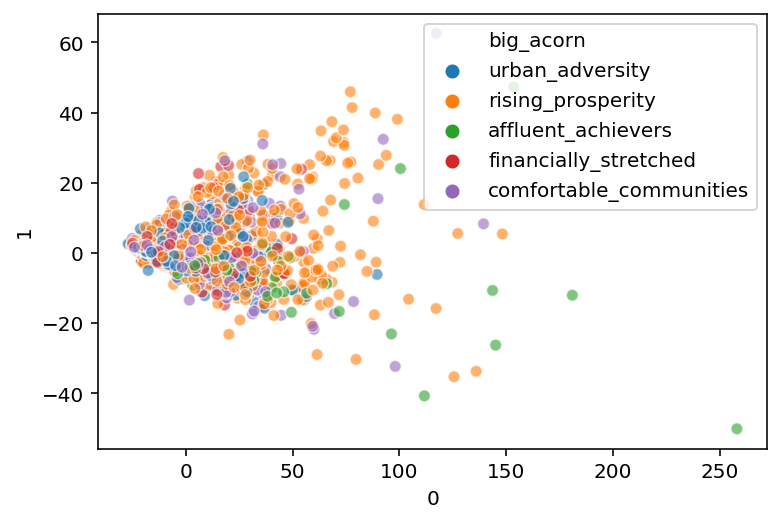

In [103]:
sns.scatterplot(
    x=z_df.loc[:, 0],
    y=z_df.loc[:, 1],
    hue=z_df.loc[:,'big_acorn'],
    alpha=0.6
);

### Plot consumption by Acorn Group

In [107]:
corn['day'] = pd.to_datetime(corn['day'])
corn.set_index('day', inplace=True)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [159]:
list_of_acorns = ['ACORN-A', 'ACORN-B', 'ACORN-C', 'ACORN-D','ACORN-E','ACORN-F','ACORN-G','ACORN-H','ACORN-I','ACORN-J','ACORN-K','ACORN-L','ACORN-M','ACORN-N','ACORN-O','ACORN-P','ACORN-Q']


In [163]:
len(corn['Acorn'].value_counts())

18

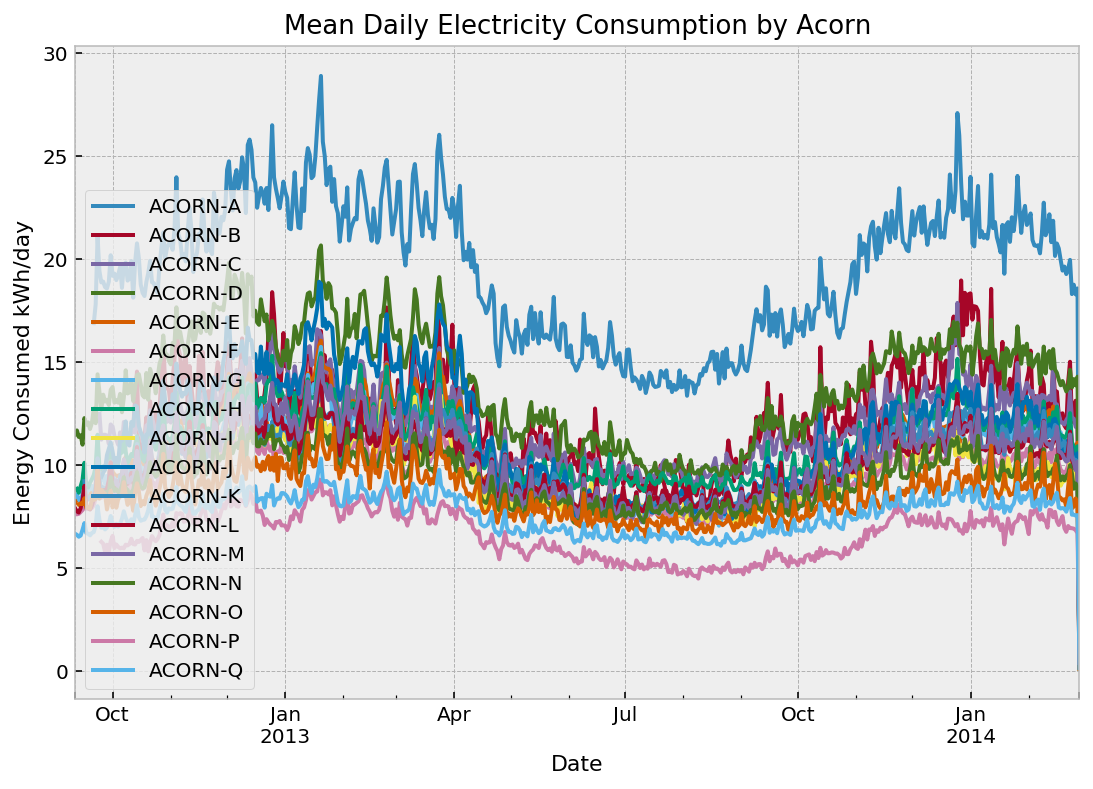

In [220]:
plt.figure(figsize=(9, 6))

for kernel in list_of_acorns:
    df = corn.loc[(corn['Acorn']==kernel), ['energy_sum']].groupby('day').mean()[293::]
    df[kernel] = df['energy_sum']
    df[kernel].plot()
plt.legend()

plt.title(label="Mean Daily Electricity Consumption by Acorn", fontsize=13)
plt.xlabel('Date', fontsize=11)
plt.ylabel('Energy Consumed kWh/day', fontsize=11)
alpha=0.6;

### Plot consumption by greater acorn group

In [184]:
corn['big_acorn'] = corn['Acorn'].map(bigger_acorns)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


#### drop the U acorn

In [189]:
corn = corn.loc[corn['Acorn']!='ACORN-U']

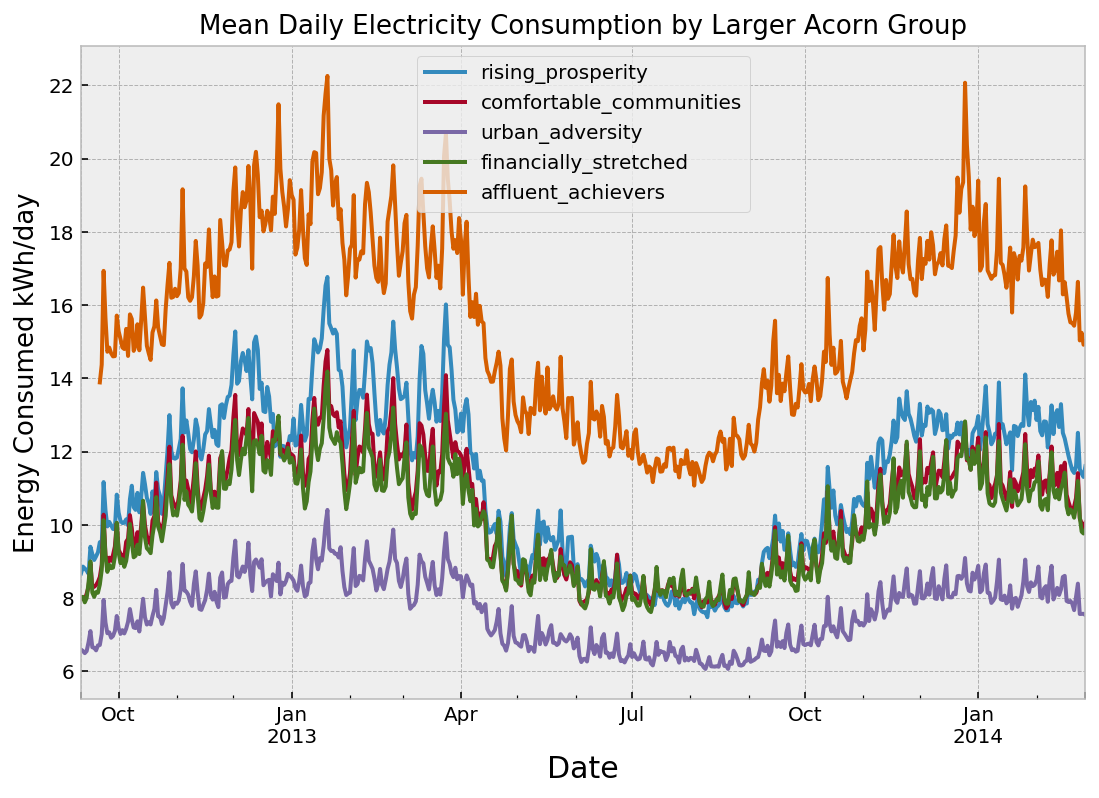

In [221]:
plt.figure(figsize=(9, 6))

for kernel in list(corn['big_acorn'].unique()):
    df = corn.loc[(corn['big_acorn']==kernel), ['energy_sum']].groupby('day').mean()[293:-1]
    df[kernel] = df['energy_sum']
    df[kernel].plot()
plt.legend()

plt.title(label="Mean Daily Electricity Consumption by Larger Acorn Group", fontsize=13)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Energy Consumed kWh/day', fontsize=13)
alpha=0.6;

#### This plot appears to show that mean energy consumption decreases in order of decreasing Large-Acorn grouping, or lower economic class. 

### Rank the Acorns and Large-Acorns in order of energy consumption

In [207]:
big_acorn_mean_ranked = corn.groupby('big_acorn').mean().sort_values(by='energy_sum', ascending=False).round(2)
big_acorn_mean_ranked['Avg Consumption (kWh/day)'] = big_acorn_mean_ranked['energy_sum']
big_acorn_mean_ranked.drop(columns='energy_sum', inplace=True)

In [208]:
big_acorn_mean_ranked

,Avg Consumption (kWh/day)
big_acorn,
affluent_achievers,15.33
rising_prosperity,10.85
comfortable_communities,10.01
financially_stretched,9.87
urban_adversity,7.55


In [209]:
acorn_mean_ranked = corn.groupby('Acorn').mean().sort_values(by='energy_sum', ascending=False).round(2)
acorn_mean_ranked['Avg Consumption (kWh/day)'] = acorn_mean_ranked['energy_sum']
acorn_mean_ranked.drop(columns='energy_sum', inplace=True)
acorn_mean_ranked

,Avg Consumption (kWh/day)
Acorn,
ACORN-A,19.09
ACORN-D,13.51
ACORN-C,11.95
ACORN-B,11.90
ACORN-J,11.35
ACORN-H,11.01
ACORN-E,10.36
ACORN-G,10.17
ACORN-L,10.03


## K Means clustering using the mean of the 6 energy features for each Acorn

In [316]:
daily.head()

,LCLid,Acorn,day,energy_median,energy_mean,energy_max,energy_std,energy_sum,energy_min
0,MAC000152,ACORN-E,2011-11-23,0.1725,0.248708,0.798,0.193996,5.969,0.055
1,MAC000153,ACORN-E,2011-11-23,0.6765,0.904250,2.407,0.592275,21.702,0.261
2,MAC000156,ACORN-F,2011-11-23,0.2745,0.296500,0.512,0.108046,6.523,0.162
3,MAC000147,ACORN-F,2011-11-23,0.0750,0.108429,0.315,0.071653,3.036,0.033
4,MAC000154,ACORN-Q,2011-11-23,0.1740,0.252087,0.999,0.219155,5.798,0.098


In [317]:
daily.shape

(3504561, 9)

In [318]:
df = daily.groupby(by='LCLid').mean()

In [319]:
acorns_to_house = daily.loc[:, ['LCLid', 'Acorn']]
acorns_to_house['id'] = acorns_to_house['LCLid']
acorns_to_house.set_index('LCLid', inplace=True)

In [320]:
acorns_to_house.drop_duplicates(subset ="id", 
                                inplace = True)
acorns_to_house.drop(columns='id', inplace=True)

In [321]:
acorns_to_house.head()

,Acorn
LCLid,
MAC000152,ACORN-E
MAC000153,ACORN-E
MAC000156,ACORN-F
MAC000147,ACORN-F
MAC000154,ACORN-Q


In [322]:
df.shape

(5534, 6)

In [323]:
df = pd.merge(df, acorns_to_house, left_index=True, right_index=True, how='left')

In [324]:
df.shape

(5534, 7)

In [325]:
df = df.loc[df['Acorn'] != 'ACORN-U',:]

In [326]:
df.shape

(5485, 7)

In [327]:
df.loc[:, 'big_acorn'] = df['Acorn'].map(bigger_acorns)

In [328]:
df.head()

,energy_median,energy_mean,energy_max,energy_std,energy_sum,energy_min,Acorn,big_acorn
LCLid,,,,,,,,
MAC000002,0.188966,0.254590,1.086095,0.208284,12.070638,0.080400,ACORN-A,affluent_achievers
MAC000003,0.169372,0.396809,1.865561,0.481075,19.028192,0.054664,ACORN-P,urban_adversity
MAC000004,0.000423,0.035391,0.236234,0.072192,1.691600,0.000184,ACORN-E,rising_prosperity
MAC000005,0.050841,0.095363,0.589262,0.108945,4.562705,0.028878,ACORN-C,affluent_achievers
MAC000006,0.048995,0.059455,0.248989,0.045976,2.848158,0.013137,ACORN-Q,urban_adversity


## K means clustering model

In [330]:
ss = StandardScaler()
X = ss.fit_transform(df.loc[:,list(df.columns.drop(['Acorn', 'big_acorn']))])

In [331]:
km = KMeans(n_clusters = 5, random_state=24)
km.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=24, tol=0.0001, verbose=0)

In [332]:
df_k1 = df
df_k1.loc[:, 'cluster'] = km.labels_
df_k1.drop(columns='Acorn', inplace=True)
df_k1.head()

,energy_median,energy_mean,energy_max,energy_std,energy_sum,energy_min,big_acorn,cluster
LCLid,,,,,,,,
MAC000002,0.188966,0.254590,1.086095,0.208284,12.070638,0.080400,affluent_achievers,4
MAC000003,0.169372,0.396809,1.865561,0.481075,19.028192,0.054664,urban_adversity,2
MAC000004,0.000423,0.035391,0.236234,0.072192,1.691600,0.000184,rising_prosperity,0
MAC000005,0.050841,0.095363,0.589262,0.108945,4.562705,0.028878,affluent_achievers,0
MAC000006,0.048995,0.059455,0.248989,0.045976,2.848158,0.013137,urban_adversity,0


### silhouette score

In [333]:
silhouette_score(X, km.labels_)

0.3795983829744658

#### Plot the clusters with color coding

<Figure size 360x360 with 0 Axes>

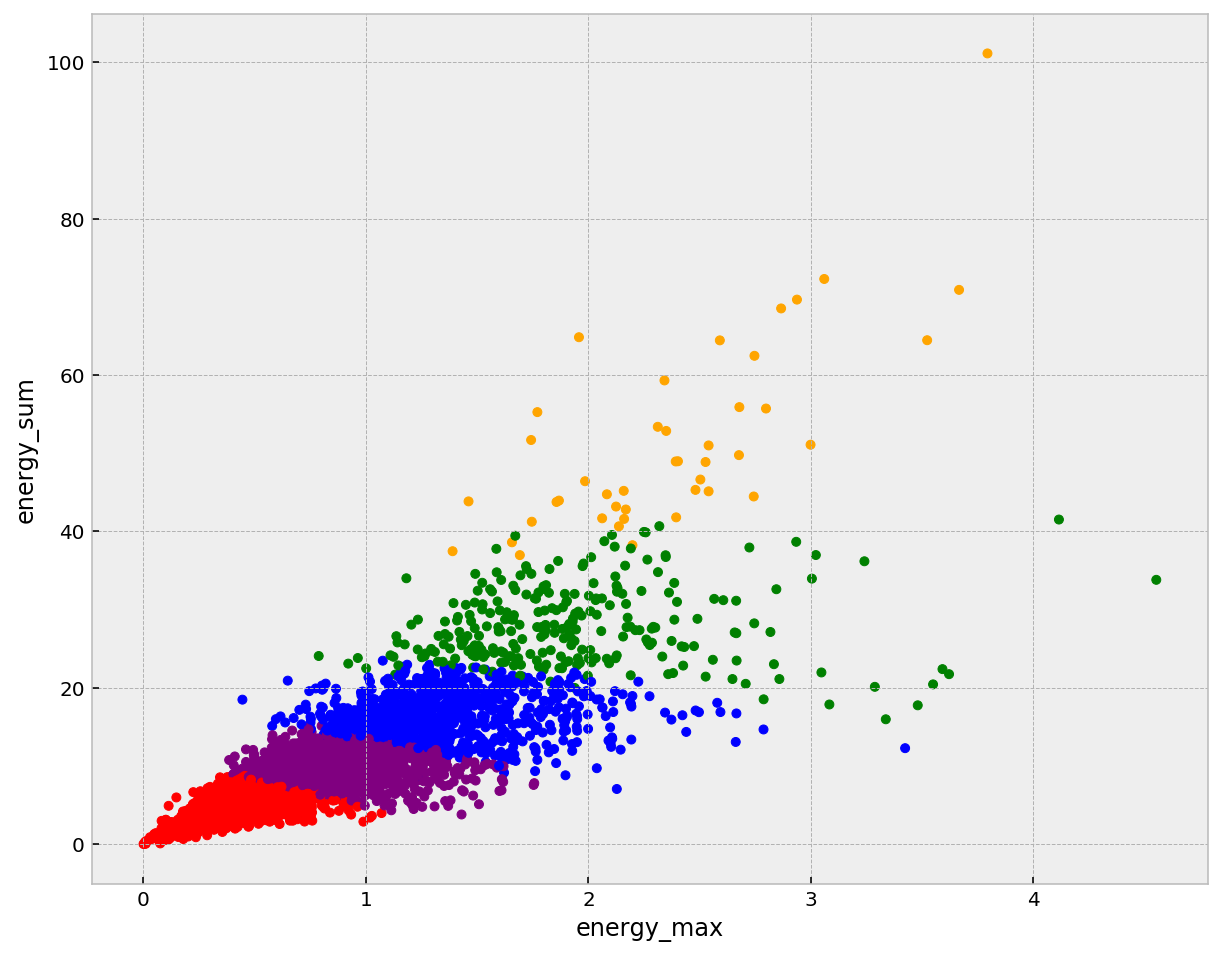

In [338]:
plt.figure(figsize=(5,5));

## Plot scatter by cluster / color, and centroids
colors = ["red", "green", "blue", 'orange', 'purple']
df_k1['color'] = df_k1['cluster'].map(lambda p: colors[p])

ax = df_k1.plot(    
    kind="scatter", 
    x="energy_max", y="energy_sum",
    figsize=(10,8),
    c = df_k1['color']
);

### Grid search for a good K

In [335]:
scores = []
for k in range(2, 31):
    cl = KMeans(n_clusters=k, random_state=24)
    cl.fit(X)
    inertia = cl.inertia_
    sil = silhouette_score(X, cl.labels_)
    scores.append((k, inertia, sil))

In [336]:
score_df = pd.DataFrame(scores, columns=['k', 'inertia', 'sil'])
score_df.head()

,k,inertia,sil
0,2,17114.466713,0.572888
1,3,11393.908279,0.484417
2,4,8772.652470,0.425538
3,5,7369.505618,0.379598
4,6,6283.105167,0.384785


Text(0.5, 1.0, 'Silhouette Score over k')

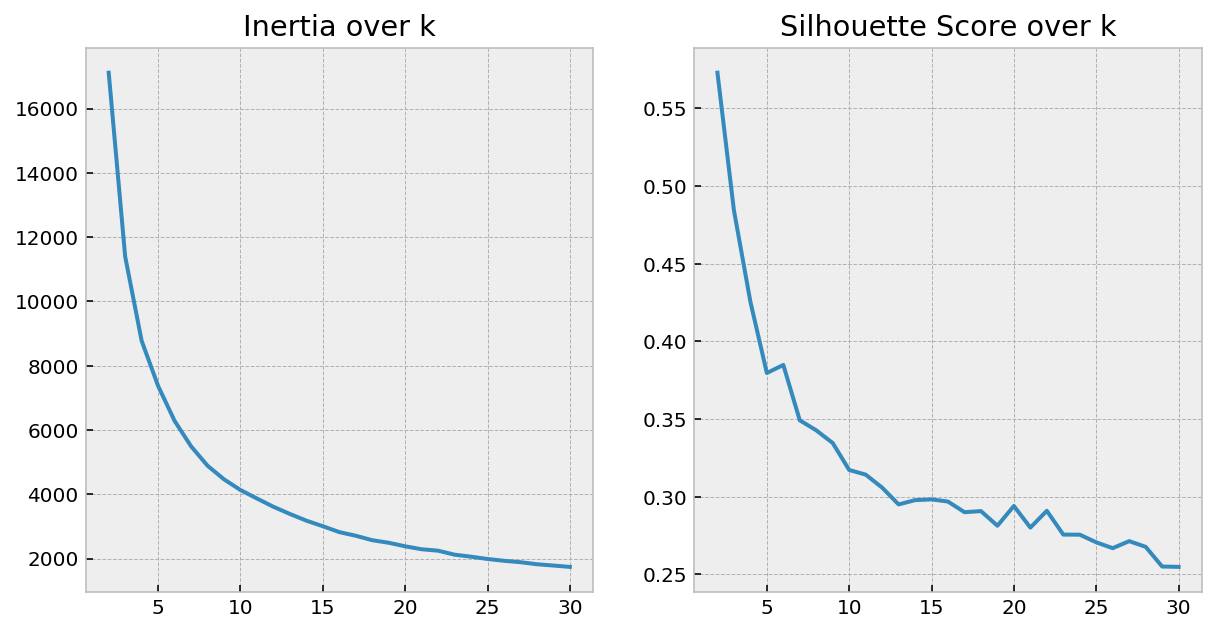

In [337]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(score_df.k, score_df.inertia)
axes[0].set_title('Inertia over k')
axes[1].plot(score_df.k, score_df.sil);
axes[1].set_title('Silhouette Score over k')

#### Besides the notable spike at 6, there don't appear to be any intuitively good values for k